## Ejercicio SOM: Predictive Maintenance

Con el dataset propuesto:

- Observar el comportamiento y distribución de los datos apoyándose de técnicas vistas durante el curso.
- Aplicar SOM para visualizar la distribución de los datos.


## Inicializamos librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from tqdm import tqdm
import seaborn as sns
import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from minisom import MiniSom

from sklearn.preprocessing import LabelEncoder

## Cargamos los datos

In [2]:
df = pd.read_csv('predictive_maintenance.csv')

In [3]:
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

## Observar el comportamiento y distribución de los datos apoyándose de técnicas vistas durante el curso.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [5]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64

In [6]:
df.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]        Target  
count            10000.000000  10000.000000     10000.000000  10000.000000  
mean              1538.776100     39.986910       107.951000      0.033900  
std                179.284096      9.968934        63.654147      0.180981  
min               1168.000000      3.800000         0.000000      0.000000  
25%               1423.000000     33.200000        53.000000      0.000000  
50%               1503.000000     40.100000       108.000000      0.000000  
75%               1612.000000     46.800000       162.000000      0.000000  
max               2886.000000     76.600000       253.000000      1.000000

In [7]:
df.Type.unique()

array(['M', 'L', 'H'], dtype=object)

In [8]:
df = pd.concat([df, pd.get_dummies(df["Type"], drop_first = True)], axis = 1, )

In [9]:
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  \
0                    1551         42.8                0       0   No Failure   
1                    1408         46.3                3       0   No Failure   
2                    1498         49.4                5       0   No Failure   
3                    1433         39.5                7       0   No Failure   
4                    1408         40.0                9       0   No Failure   

   L  M  
0  0  1  
1  1  0  
2  1  0  
3  1  0  
4  1  0

In [10]:
df.drop(["UDI", "Product ID", "Type"], inplace = True, axis = 1)

In [11]:
df.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  L  M  
0         42.8                0       0   No Failure  0  1  
1         46.3                3       0   No Failure  1  0  
2         49.4                5       0   No Failure  1  0  
3         39.5                7       0   No Failure  1  0  
4         40.0                9       0   No Failure  1  0

In [12]:
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [14]:
encoder = LabelEncoder()

In [15]:
encoder.fit(df["Failure Type"])

LabelEncoder()

In [16]:
df["Failure Type Code"] = encoder.transform(df["Failure Type"])

In [17]:
df["Failure Type Code"].value_counts()

1    9652
0     112
3      95
2      78
5      45
4      18
Name: Failure Type Code, dtype: int64

In [18]:
df.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  L  M  Failure Type Code  
0         42.8                0       0   No Failure  0  1                  1  
1         46.3                3       0   No Failure  1  0                  1  
2         49.4                5       0   No Failure  1  0                  1  
3         39.5                7       0   No Failure  1  0                  1  
4         40.0                9       0   No Failure  1  0                  1

In [19]:
targets = df[["Target", "Failure Type", "Failure Type Code"]]

In [20]:
targets.head()

Target Failure Type  Failure Type Code
0       0   No Failure                  1
1       0   No Failure                  1
2       0   No Failure                  1
3       0   No Failure                  1
4       0   No Failure                  1

In [21]:
targets.sort_values("Failure Type Code", inplace = True)

/Users/franvaquer92/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [22]:
df.drop(["Target", "Failure Type", "Failure Type Code"], inplace = True, axis = 1)

In [23]:
df.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  L  M  
0         42.8                0  0  1  
1         46.3                3  1  0  
2         49.4                5  1  0  
3         39.5                7  1  0  
4         40.0                9  1  0

In [24]:
scaler=StandardScaler()

df_norm = df.copy()
df_norm[df_norm.columns] = scaler.fit_transform(df[df.columns])

In [25]:
df_norm.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0            -0.952389                -0.947360                0.068185   
1            -0.902393                -0.879959               -0.729472   
2            -0.952389                -1.014761               -0.227450   
3            -0.902393                -0.947360               -0.590021   
4            -0.902393                -0.879959               -0.729472   

   Torque [Nm]  Tool wear [min]         L         M  
0     0.282200        -1.695984 -1.224745  1.528617  
1     0.633308        -1.648852  0.816497 -0.654186  
2     0.944290        -1.617430  0.816497 -0.654186  
3    -0.048845        -1.586009  0.816497 -0.654186  
4     0.001313        -1.554588  0.816497 -0.654186

In [26]:
df_norm.describe().round(2)

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count             10000.00                 10000.00                10000.00   
mean                 -0.00                    -0.00                   -0.00   
std                   1.00                     1.00                    1.00   
min                  -2.35                    -2.90                   -2.07   
25%                  -0.85                    -0.81                   -0.65   
50%                   0.05                     0.06                   -0.20   
75%                   0.75                     0.74                    0.41   
max                   2.25                     2.56                    7.51   

       Torque [Nm]  Tool wear [min]         L         M  
count     10000.00         10000.00  10000.00  10000.00  
mean          0.00             0.00      0.00     -0.00  
std           1.00             1.00      1.00      1.00  
min          -3.63            -1.70     -1.22     -0.65  
25%          -0.68            -0.86     -1.22     -0.65  
50%           0.01             0.00      0.82     -0.65  
75%           0.68             0.85      0.82      1.53  
max           3.67             2.28      0.82      1.53

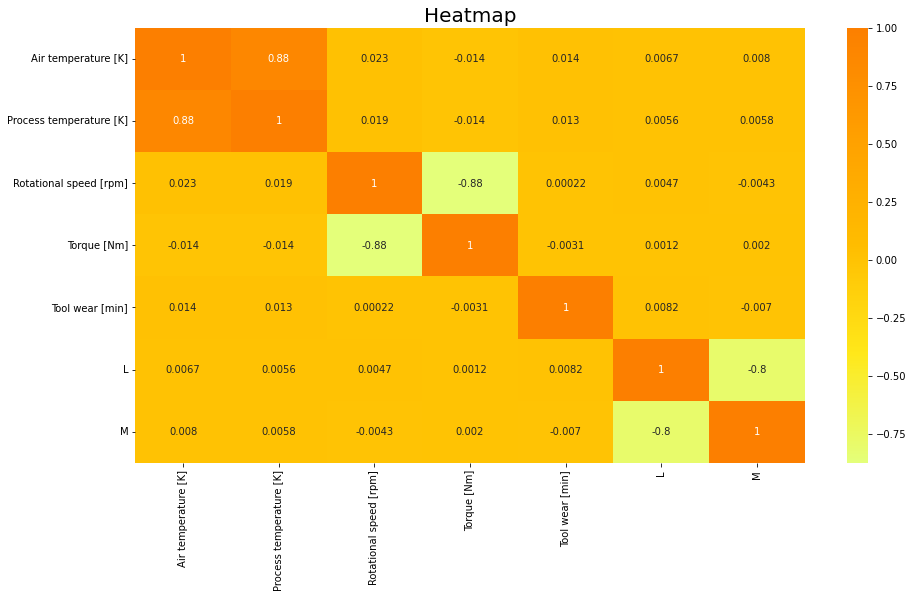

In [27]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(df_norm.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap', fontsize = 20)
plt.show()

## Aplicar SOM para visualizar la distribución de los datos.

In [28]:
targets["Failure Type"].unique()

array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure'],
      dtype=object)

In [29]:
X = df_norm.values

In [30]:
som = MiniSom(6, 6, 7, sigma=0.3, learning_rate=0.5) # Inicializamos un mapa de 6x6 neuronas y 7 features
som.train(X, 100) # entrenamos el SOM con 100 iteraciones

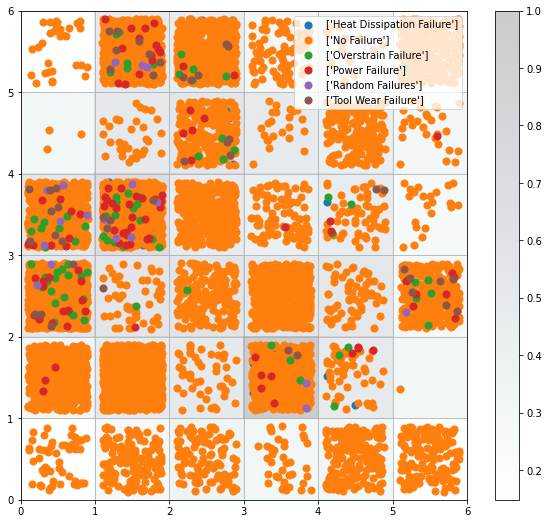

In [31]:
w_x, w_y = zip(*[som.winner(d) for d in X])
w_x = np.array(w_x)
w_y = np.array(w_y)

plt.figure(figsize=(10, 9))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()
colors = ["C0", "C1", "C2", "C3", "C4", "C5"]

for c in np.unique(targets["Failure Type Code"]):
    idx_target = targets["Failure Type Code"]==c
    plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                s=50, c=colors[c], 
                label=targets[targets["Failure Type Code"] == c]["Failure Type"].unique())
plt.legend(loc='upper right')
plt.grid()
plt.show()

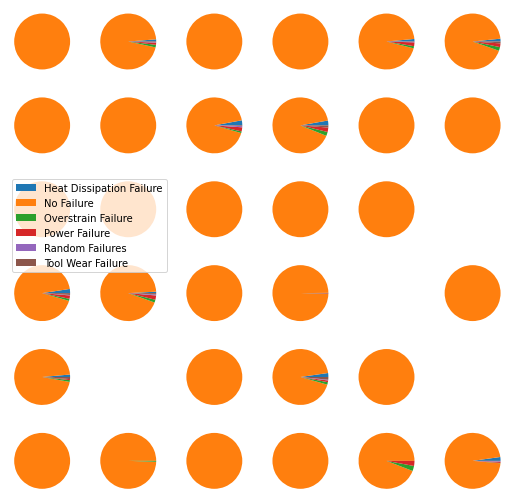

In [146]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(X, [targets["Failure Type"].unique()[t] for t in targets["Failure Type Code"]])

fig = plt.figure(figsize=(9, 9))
the_grid = gridspec.GridSpec(6, 6, fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in targets["Failure Type"].unique()]
    plt.subplot(the_grid[6-1-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)

plt.legend(patches, targets["Failure Type"].unique(), loc = "upper left")
plt.show()